**Introduction to AI and machine M505 assignment**

**GH1017458**

**Predicting Home Prices in Banglore**
<p>I am working as a Data Scientist in a real estate company working out of Bangalore,India. My company needs a website where customers can log in and select the house features like <b>area, number of bedrooms,number of bathrooms, location</b> etc and the web application would return the <b>predicted price</b>. In this notebook I have build and trained a model to predict the same. This model would further be handed to a ML engineering team and it would serve as the back end api to this web application.</p>
<p>We are going to use Python libraries, Numpy, Pandas, Matplotlib and sklearn. </p>


[Link to the dataset](https://drive.google.com/file/d/1XxdxY-0Xkdbvbph2qG2rUUVRDmwkDPFp/view?usp=sharing)

**Content**

- Importing Libraries
- Loading Data
- Feature Engineering
- Dimensionality Reduction
- Outlier Removal Using Business Logic
- Training Model
- Evaluation
- Tuning hyperparameters
- Finding best algorithm
- Retraining with best algorithm
- Exporting the model to a pickle file
- Observations and Discussions
- Conclusion and Future improvements

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

import warnings
#### This is to ignore the warnings 
warnings.filterwarnings("ignore")

**Loading Data**

In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

<i>We will be dropping the features that are not required to build our model</i>

In [4]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


<i>Data Cleaning: Checking for NA values</i>

In [5]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

<i>Dropping the NA values</i>

In [6]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

**Feature Engineering**
<p><i>1. Since our data has size column which is not in desired format we add a new feature(integer) for bhk (Bedrooms Hall Kitchen). This would help us further with our analysis</i></p>

In [7]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


<i>Checking if total square feet is empty or not and then converting it to a float for further analysis. For this we have written a isFloat function</i>

In [8]:
def isfloat(x):
    try:
        float(x)
    except:
        return False
    return True


In [9]:
df3['total_sqft'].apply(isfloat)==False

0        False
1        False
2        False
3        False
4        False
         ...  
13315    False
13316    False
13317    False
13318    False
13319    False
Name: total_sqft, Length: 13246, dtype: bool

*So we find out that there are many values that are not a number. Therefore we drop it*

In [10]:
df3[~df3['total_sqft'].apply(isfloat)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


<i>The next challenge is to handle values which are a range(e.g. 2100-2850) rather than a single number. For such case we can just take average of min and max value in the range. 
There are also values which are not in the correct unit. We will drop those too.</i>

In [11]:
def convert_range_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None 

In [12]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_range_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


<b>2. Adding a new feature called price_per_square_feet</b>
<p><i>We are adding this column to remove outliers later. Since the prices are in lakhs therefore we have to multiply the price by 100000</i></p>

In [13]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [14]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

<i>We will be saving this dataframe into a csv file as this is our final cleaned data. Later if we want we can start our model building right on this file. </i>

In [15]:
df5.to_csv("bangaloreHomePrices.csv",index=False)

In [16]:
np.count_nonzero(df5['location'].unique())

1298

<i>We now see that there are 1298 unique locations. If we encode this value the data will become huge. So we need to apply dimensionality reduction technique here to reduce number of locations. We will categorize all locations under 10 occurences under 'Others' category. </i>

<i>Firstly we remove spaces from the location name and then check the occurences in descending order. </i>

In [17]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

<b>Dimensionality Reduction</b>


In [18]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10


BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

<i>These 1047 records will be grouped under 'Others' Category. </i>

In [19]:
df5.location = df5.location.apply(lambda x: 'Others' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

**Outlier Removal Using Business Logic**


<i>After discussion with the client manager(who has expertise in real estate), we find that normally area of a house per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft) . Therefore any data points not following the above trend will be removed as outliers<i>

In [20]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,Others,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,Others,3 Bedroom,500.0,3.0,100.0,3,20000.000000


<i>Clearly 6 bedroom, 6 bathroom homes will not be 1020 sq feet. So we have to remove these too. </i>

In [21]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

<i>Now we have to find out a way to remove these outliers. For this we can use standard deviation and mean function. </i>

In [22]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

<i>The above reults clearly shows that minimum price is 267 rs/sqft whereas maximum is 176470 rs/sqft, which is a huge range. Therefore we should remove outliers per location using mean and one standard deviation. </i>

In [23]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

<i> We now plot the result in a scatter plot to visualise the data of 2 bedrooms and 3 bedrooms flat. </i>

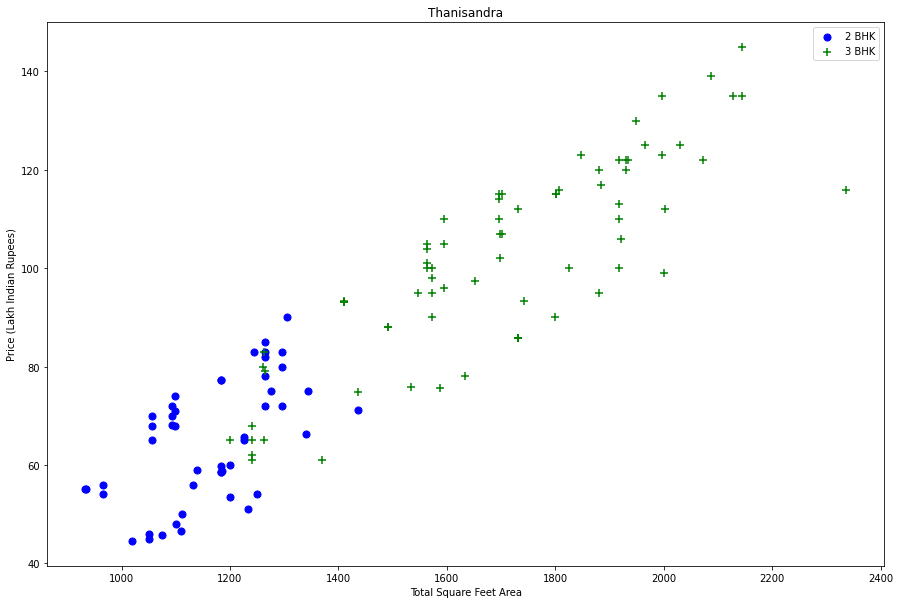

In [24]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Thanisandra")


<i> This clearly shows that there are few 3 bedroom homes with prices lower that 2 bedroom home for a given area. <i>

*We will have to remove these outliers. For this we will be using a the below standard deviation and mean dictionary i.e.*

<p>{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}</p>


*Now we will be removing those 3 bedroom homes whose price_per_sqft is less than mean price_per_sqft of 2 bedroom home*

In [25]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)

df8.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


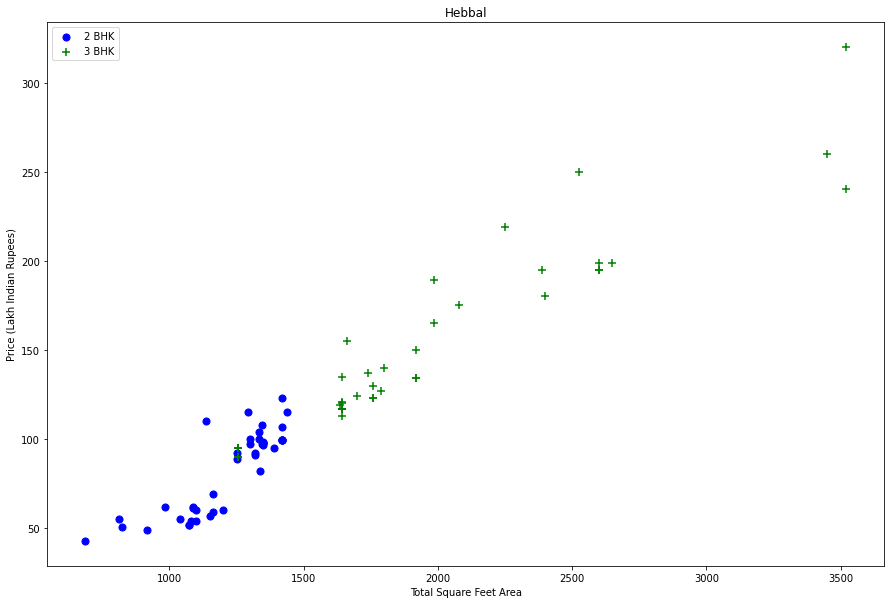

In [26]:
plot_scatter_chart(df8,"Hebbal")

*We next have to remove Outliers using Bathrooms Feature*

In [27]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
5926,Others,10 BHK,12000.0,12.0,525.0,10,4375.000000
6015,Others,16 BHK,10000.0,16.0,550.0,16,5500.000000
6749,Others,11 BHK,6000.0,12.0,150.0,11,2500.000000
7080,Others,13 BHK,5425.0,13.0,275.0,13,5069.124424


*So we clearly see that some homes are having more bathrooms than bedroom which is again not correct. So we again consult with our client manager to find how to remove this discrepancy.*

*We find out from the client manager that even if each bedroom has an attach bath and we have an extra bathroom for guest, it will be very unlikely to have 2 more bathrooms than number of bedrooms in a home. So using this rule we further narrow down our data.*

In [28]:
df9=df8[~(df8.bath>df8.bhk+2)]
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


*We can now drop the column for size and price per square feet as we donot require it anymore.*

In [29]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


*We used simple one hot encoding, but we got negative score for linear regression. Please find the image below.*


![](negativeAccuracy.PNG)

*Since we got negative score by using simple one hot encoding we would encode the whole data set using Column Transformer. This allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.*

In [30]:
X = df10.drop(['price'],axis='columns').values
y = df10.price

ct = ColumnTransformer([("Location", OneHotEncoder(), [0])], remainder = 'passthrough')
X = ct.fit_transform(X)


*Splitting our test and train data*

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


**Now we can start building and training our model**

In [32]:
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8350152398039354

**Now we will be using K Fold cross validation to measure accuracy of our LinearRegression model**

In [33]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84216239, 0.85486119, 0.76801722, 0.84562507, 0.87236654,
       0.82714705, 0.8336241 , 0.8346691 , 0.86183444, 0.80118345])

<p><i>We can clearly observe that in all the iterations we get a score around 80%. But we will be testing other algorithms for better results if possible. We will be using GridSearchCV.</i></p>
<p><i>We have written a function below where we have defined the parameters of each algorithm in a dictionary variable. Then we iterate through this dictionary variable and call the GridSearchCV module with the respective params to find out the best score. We then append the result in a pd dataframe for a better view.</i></p> 

In [34]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        
       'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
       },
        
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)


,model,best_score,best_params
0,linear_regression,0.834157,{'normalize': True}
1,lasso,0.697940,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.756265,"{'criterion': 'mse', 'splitter': 'random'}"


<i>We retrain our model with the best algo and the best hyperparameter that we found.</i>

In [35]:
lr_clf_withBestHyperparameters = LinearRegression(normalize=True)
lr_clf_withBestHyperparameters.fit(X_train,y_train)
y_pred=lr_clf_withBestHyperparameters.predict(X_test)
predicted_df=pd.DataFrame(y_pred,columns=['PredictedPrice'])
predicted_df.head()

,PredictedPrice
0,38.578644
1,109.419628
2,27.385701
3,126.095902
4,84.529053


<i>We find the R squared metric to determine the performance. Unlike other metric like mean squared error and mean absolute error which returns an arbitarily big value(generally hard to interpret), r2 always returns a value less than equal to 1, hence it is easier to interpret and determine the performance.</i>

In [36]:
r2_score(y_test, y_pred)

0.835014994232861

**Exporting the model to a pickle file**

<i>This pickle file will be used by our engineering team and will be fed to the python flask server and it will serve as the back end for it </i>

In [37]:
import pickle
with open('banglore_home_prices.pickle','wb') as f:
    pickle.dump(lr_clf_withBestHyperparameters,f)

<b>Observations and Discussions</b>
<p>We see that the housing data set had few issues which we have cleaned. Firstly we dropped 'area_type', 'society', 'balcony', 'availability' as these column doesnt affect our prices much(in accordance with the client manager). We then removed outliers by help of adding some features. We also applied business logic with the help of our client manager to identify few outliers and removed it to increase the performance of our model. As discussed above, when we tried encoding the data sepately after splitting it resulted in negative score. Therefore we applied One Hot Encoding separately on the whole dataset and then splitted it into our train and test sets.</p>

<b>Conclusion and Future improvements</b> 
<p> The above analysis clearly shows that Linear Regression is the best algo for this problem. Therefore we retrain our model post tuning the hyperparametes and then predict the prices again. We have also calculated R squared metric to check our performance which is around 84%. As our next steps we will be exporting this model as a pickle file(shown above) and will be sharing this with our engineering team. They would then build a UI for customers for predicting home prices across all locations in Bangalore.</p> 
   <p>Since we do not get much different results from all the algoriths used, we can conclude that to further enhance the accuracy of prediction we would require more features. We have planned to retrain the model with more data as and when available and would also like to add more features as <b>'Floor number','Parking available','Furnished/Unfurnished','Distance from City Center'</b> etc. </p>